# Fitting 1-D model using Pytorch

In this notebook I'm going to show how to use Pytorch for the 1-D model analysis. As an example, I will use only one subject's data.

In [6]:
import sys
sys.path.append('/Users/jh7685/Dropbox/NYU/Projects/SF')
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import itertools
import nibabel as nib
import numpy as np
import pandas as pd
import h5py
import itertools
import pandas as pd
from matplotlib import pyplot as plt
from Scripts import binning_eccen
import torch


In [7]:
sn_list = np.arange(1, 2)

Each subject's voxel-wise and stimulus-wise information is stored in a dataframe. In the next cell, I'm going to load a dataframe of one subject and average beta values and local frequency values grouped by each eccentricity bin (here we ignore stimulus class). Then I will plot beta values as a function of spatial frequency for each eccentricity bin.  I already made my own functions for making, loading and plotting the results, which are written in a script called `binning_eccen.py`. So, what I'm doing here is I load the script, and call those specific functions that I need.

/Users/jh7685/opt/miniconda3/envs/sfp/lib/python3.7/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


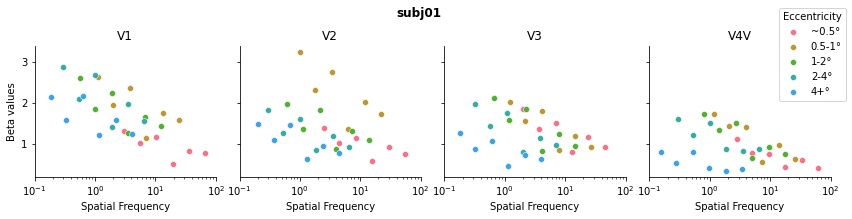

In [8]:
for sn in sn_list:
    subj = "%s%s" % ('subj', str(sn).zfill(2))
    mean_df = binning_eccen.main_binning(subj=subj, central_tendency=["mean"])
    grid = binning_eccen.plot_2D(mean_df=mean_df, subj=subj, save_fig=False)

Now we know how the data looks like.

# 1-D model optimization

As a next step, we are going to find three parameters of a pdf of log normal distribution that would make a best fit to data for each eccentricity bin condition. This step will be done using Pytorch. The step will be:
    1. Set an objective function that we want to find the best fit: log normal distribution
    2. Set initial values for the three parameters (amplitude, mode, & sigma)
    3. Select an optimizer type that we are going to use
    4. Set a loss function
    5. Run optimization
    6. Check error values & final parameter values.


In [9]:
import torch

Before going into the step, we need to convert every numpy array (normal arrays used in Python) to tensor type array, which is a specialized array type for calculation backed by GPU. Those two types cannot be used together.

## step 1. Set an objective function

In [12]:
def log_norm_pdf(x, a, mode, sigma):
    """the pdf of the log normal distribution, with a scale factor
    """
    # note that mode here is the actual mode, for us, the peak spatial frequency. this differs from
    # the 2d version we have, where we we have np.log2(x)+np.log2(p), so that p is the inverse of
    # the preferred period, the ivnerse of the mode / the peak spatial frequency.
    pdf = a * torch.exp(-(torch.log2(x)-torch.log2(mode))**2/(2*sigma**2))

    return pdf

Let's say we are fitting beta values of voxels in V1 that correspond to eccentricity 2-4°. Here I first filter out rows that qualifies the condition.

In [14]:
single_df = mean_df.droplevel(level=1, axis=1)
single_df = single_df.query("vroinames=='V1' & eccrois==3.0")
single_df.head()

,vroinames,eccrois,freq_lvl,beta,local_ori,local_sf
12,V1,3.0,0,2.601723,1.544276,0.557919
13,V1,3.0,1,1.851101,1.544276,1.000290
14,V1,3.0,2,2.253546,1.544276,1.904856
15,V1,3.0,3,1.252199,1.575187,3.525237
16,V1,3.0,4,1.658985,1.544276,6.619134


And now I define x and y values from the dataframe. The `x` and `y` variables should be tensor arrays, so here I convert them from numpy to tensor.

In [15]:
x = torch.from_numpy(single_df.local_sf.values).to(torch.float32)
y = torch.from_numpy(single_df.beta.values).to(torch.float32)

## step 2. Set initial parameters
We are going to start fitting from 1 for all parameters. Let's see how these values (now 1) change after optimization. `requires_grad=True` option indicates that we will track computation with them.

In [16]:
amp = torch.tensor([1], dtype=torch.float32, requires_grad=True)
mode = torch.tensor([1], dtype=torch.float32, requires_grad=True)
sigma = torch.tensor([1], dtype=torch.float32, requires_grad=True)

## step 3. Select an optimizer
Choose an optimizer. As you use neural networks, you want to use various different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc. To enable this, we built a small package: torch.optim that implements all these methods. Adam is the most commonly used optimizer. `lr` means learning rate. (As for now I have no reason to set this .02)

In [17]:
optimizer = torch.optim.Adam([amp, mode, sigma], lr=.02)

## step 4. Set a loss function
A loss function takes the (output, target) pair of inputs, and computes a value that estimates how far away the output is from the target. There are several different loss functions under the nn package. A simple loss is: `nn.MSELoss` which computes the mean-squared error between the input and the target.

In [18]:
torch.nn.functional.mse_loss(log_norm_pdf(x, amp, mode, sigma), y)

tensor(2.1245, grad_fn=<MseLossBackward0>)

## step 5. Optimization
Now we decide how many times we want to run the optimization (calculate error - fix - calculate agian - fix ...).
To backpropagate the error, all we have to do is to `loss.backward()`. Importantly, before going on to the next step, you need to clear the existing gradients though, else gradients will be accumulated to existing gradients. To see how steeply the error decreases later, we will store error at each step in `losses`.

In [27]:
n_opt = 1000
losses = torch.empty(n_opt)
for i in range(n_opt):
    loss = torch.nn.functional.mse_loss(log_norm_pdf(x, amp, mode, sigma), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses[i] = loss

## step 6. Check error slope & final parameter values
Let's first check how parameters changed through the process.

In [28]:
print([amp, mode, sigma])

[tensor([2.3847], requires_grad=True), tensor([0.2682], requires_grad=True), tensor([4.7525], requires_grad=True)]


Amplitude, mode, and sigma all increased over 1. Now let's see whether our loss function worked well and the MSE continuously decreased.

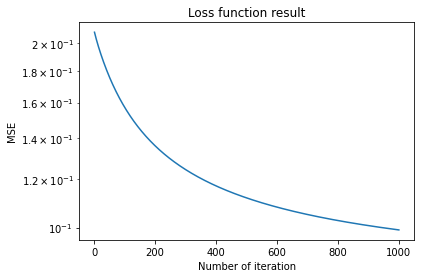

In [30]:
plt.semilogy(np.arange(1, n_opt+1), losses.detach().numpy())
plt.title('Loss function result')
plt.xlabel('Number of iteration')
plt.ylabel('MSE')
plt.show()

Finally, we can see how the log normal function looks like with the final parameters.

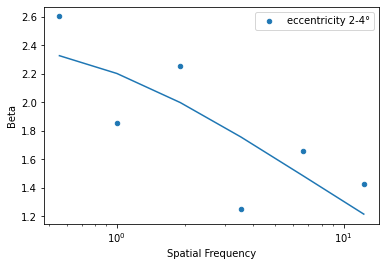

In [31]:
plt.plot(x.numpy(), log_norm_pdf(x, amp, mode, sigma).detach().numpy())
plt.xlabel('Spatial Frequency')
plt.ylabel('Beta')
plt.scatter(single_df.local_sf.values, single_df.beta.values, s=20, label='eccentricity 2-4°')
plt.xscale('log')
plt.legend()
plt.show()